In [1]:
from fedn import APIClient
import time
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

import sys
sys.path.append('/home/ubuntu/fedn-attack-sim-uu/examples/iris-sklearn')

from combiner_config import COMBINER_IP

In [2]:
DISCOVER_HOST = COMBINER_IP
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

In [3]:
[session['session_id'] for session in client.list_sessions()['result']]

['IRIS_TEST_03', 'IRIS_TEST_02', 'IRIS_TEST_01']

In [4]:
session_id = input("Provide a session_id: ")

Provide a session_id:  IRIS_TEST_03


In [6]:
baseline_session_id = input("Provide baseline session_id: ")

Provide baseline session_id:  IRIS_TEST_03


In [8]:
models = client.list_models(session_id)
# models

In [9]:
num_rounds = models['count']
num_rounds

10

In [10]:
# Provides a model trail for a given session (in FILO) --> need to be reversed
model_trail = models['result']
model_trail.reverse()
model_trail

[{'committed_at': 'Fri, 19 Apr 2024 14:27:25 GMT',
  'model': '23ea322e-41cf-45ca-b7e8-965a6e250d43',
  'session_id': 'IRIS_TEST_03'},
 {'committed_at': 'Fri, 19 Apr 2024 14:27:30 GMT',
  'model': '16688e4a-ae46-410a-9c05-6d6edc1b0e69',
  'session_id': 'IRIS_TEST_03'},
 {'committed_at': 'Fri, 19 Apr 2024 14:27:35 GMT',
  'model': '6fc43439-f625-4af4-b6f3-2c394c4078ee',
  'session_id': 'IRIS_TEST_03'},
 {'committed_at': 'Fri, 19 Apr 2024 14:27:40 GMT',
  'model': '479e4701-cdfc-4452-8554-40e50cc31b32',
  'session_id': 'IRIS_TEST_03'},
 {'committed_at': 'Fri, 19 Apr 2024 14:27:45 GMT',
  'model': '48065324-3171-42d3-89d2-52bab484fcba',
  'session_id': 'IRIS_TEST_03'},
 {'committed_at': 'Fri, 19 Apr 2024 14:27:50 GMT',
  'model': '23a99fb8-816e-419c-a32c-af4e709fe8f7',
  'session_id': 'IRIS_TEST_03'},
 {'committed_at': 'Fri, 19 Apr 2024 14:27:56 GMT',
  'model': 'ad8649f2-71d3-4a18-978a-ba964bcf5a41',
  'session_id': 'IRIS_TEST_03'},
 {'committed_at': 'Fri, 19 Apr 2024 14:28:01 GMT',
  'm

In [12]:
client.list_validations(modelId=model_trail[0]['model'])

{'66227f4f87696a0ad2092dea': {'data': '{"training_loss": 4.641558339431638, "training_accuracy": 0.39153846153846156, "test_loss": 4.762628784451232, "test_accuracy": 0.38769230769230767, "coef_": [[-3.2396749632270905, 1.3320139646609914, 0.44230429570539886, 5.726586277827045], [-0.28002727011809475, -0.6507254330382969, 0.2932193712680611, -0.06710493880814802], [1.9215111987509168, -1.583746421403812, 0.21549243264270324, -3.9095923399263377]], "intercept_": [0.056639037119228866, -0.058615715396351825, -0.29561663222142026]}',
  'meta': '',
  'model_id': '23ea322e-41cf-45ca-b7e8-965a6e250d43',
  'receiver': {'name': 'combiner', 'role': 'COMBINER'},
  'sender': {'name': 'benign_client3', 'role': 'WORKER'},
  'timestamp': '2024-04-19T14:27:27.663015Z'},
 '66227f4f87696a0ad2092deb': {'data': '{"training_loss": 4.786242332259795, "training_accuracy": 0.37615384615384617, "test_loss": 4.659189372908085, "test_accuracy": 0.38153846153846155, "coef_": [[-3.2396749632270905, 1.33201396466

In [17]:
client.list_validations(modelId=model_trail[3]['model'])

{'66227f5e87696a0ad2092e3e': {'data': '{"training_loss": 4.588963316055232, "training_accuracy": 0.39076923076923076, "test_loss": 4.824161614880495, "test_accuracy": 0.40307692307692305, "coef_": [[-3.239674963227091, 1.3320139646609914, 0.44230429570539864, 5.726586277827045], [-0.28002727011809475, -0.6507254330382969, 0.29321937126806114, -0.06710493880814801], [1.9215111987509168, -1.583746421403812, 0.21549243264270335, -3.909592339926338]], "intercept_": [0.056639037119228866, -0.058615715396351825, -0.2956166322214203]}',
  'meta': '',
  'model_id': '479e4701-cdfc-4452-8554-40e50cc31b32',
  'receiver': {'name': 'combiner', 'role': 'COMBINER'},
  'sender': {'name': 'benign_client1', 'role': 'WORKER'},
  'timestamp': '2024-04-19T14:27:42.740940Z'},
 '66227f5e87696a0ad2092e40': {'data': '{"training_loss": 4.610841618840716, "training_accuracy": 0.38153846153846155, "test_loss": 4.642187183979709, "test_accuracy": 0.36615384615384616, "coef_": [[-3.239674963227091, 1.33201396466099

In [13]:
validations = []

for model_instance in model_trail:
    worker_results = client.list_validations(modelId=model_instance['model'])
    result_ids = [result_id for result_id in worker_results]
    for result_id in result_ids:
        worker_result = worker_results.get(result_id)
        client_type = 'benign'
        
        if 'malicious' in worker_result['sender']['name']:
            client_type = 'malicious'
            
        validation = {
            'model_committed_at': model_instance['committed_at'],
            'session_id': model_instance['session_id'],
            'model': model_instance['model'],
            'client_name': worker_result['sender']['name'],
            'client_role': worker_result['sender']['role'],
            'client_type': client_type,
            'coef_': json.loads(worker_result['data'])['coef_'],
            'intercept_': json.loads(worker_result['data'])['intercept_']
        }
        
        validations.append(validation)
        

In [56]:
# validations

In [57]:
# set([validation['client_name'] for validation in validations])

In [58]:
graph_data = {
    'training_loss': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'training_accuracy': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_loss': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_accuracy': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'overall_training_loss': [],
    'overall_training_accuracy': [],
    'overall_test_loss': [],
    'overall_test_accuracy': []
}

In [59]:
for validation in validations:
    graph_data['training_loss'][validation['client_name']]['data'].append(validation['training_loss'])
    graph_data['training_accuracy'][validation['client_name']]['data'].append(validation['training_accuracy'])
    graph_data['test_loss'][validation['client_name']]['data'].append(validation['test_loss'])
    graph_data['test_accuracy'][validation['client_name']]['data'].append(validation['test_accuracy'])

In [60]:
graph_data['overall_training_loss'] = [np.mean([graph_data['training_loss'][key]['data'][i] for key in graph_data['training_loss'].keys()]) for i in range(num_rounds)]
graph_data['overall_training_accuracy'] = [np.mean([graph_data['training_accuracy'][key]['data'][i] for key in graph_data['training_accuracy'].keys()]) for i in range(num_rounds)]
graph_data['overall_test_loss'] = [np.mean([graph_data['test_loss'][key]['data'][i] for key in graph_data['test_loss'].keys()]) for i in range(num_rounds)]
graph_data['overall_test_accuracy'] = [np.mean([graph_data['test_accuracy'][key]['data'][i] for key in graph_data['test_accuracy'].keys()]) for i in range(num_rounds)]

In [61]:
# graph_data

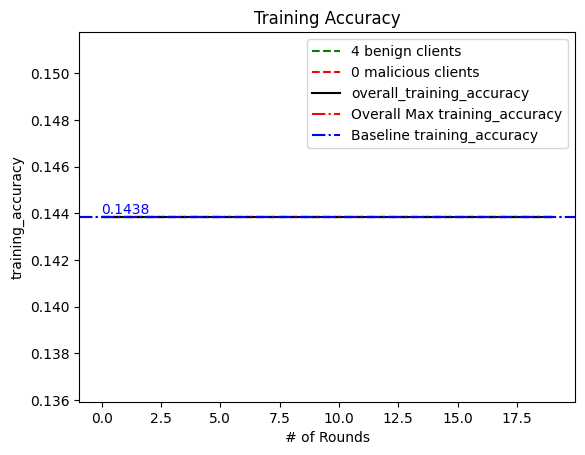

In [62]:
x = range(num_rounds)
metric_type = "training_accuracy"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'overall_{metric_type}')

# Add a horizontal line for baseline max and overall max accuracies
if 'loss' in metric_type:
    plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type}')
else:
    plt.axhline(y=np.max(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Max {metric_type}')
plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(f'Training Accuracy')
plt.xlabel(f'# of Rounds')
plt.ylabel(f'{metric_type}')

# Create legend with custom labels
plt.legend()

plt.show()

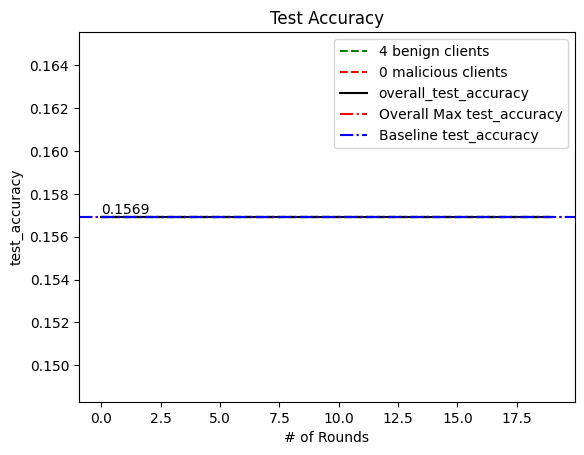

In [63]:
x = range(num_rounds)
metric_type = "test_accuracy"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'overall_{metric_type}')

# Add a horizontal line at y = 3
if 'loss' in metric_type:
    plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type}')
else:
    plt.axhline(y=np.max(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Max {metric_type}')
plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom')

# Add axis labels and title
plt.title(f'Test Accuracy')
plt.xlabel(f'# of Rounds')
plt.ylabel(f'{metric_type}')

# Create legend with custom labels
plt.legend()

plt.show()

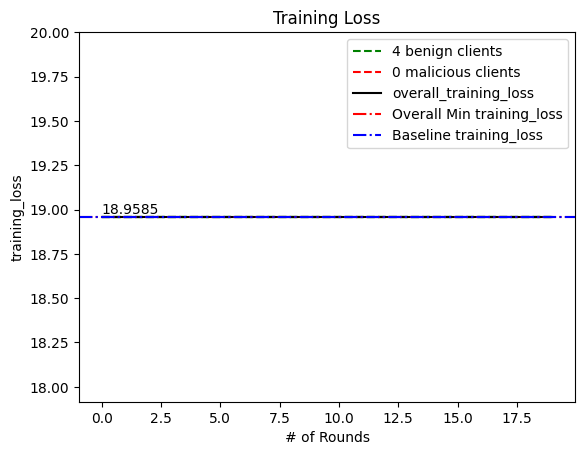

In [64]:
x = range(num_rounds)
metric_type = "training_loss"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'overall_{metric_type}')

# Add a horizontal line for baseline min and overall min losses
if 'loss' in metric_type:
    plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type}')
else:
    plt.axhline(y=np.max(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Max {metric_type}')
plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom')

# Add axis labels and title
plt.title(f'Training Loss')
plt.xlabel(f'# of Rounds')
plt.ylabel(f'{metric_type}')

# Create legend with custom labels
plt.legend()

plt.show()

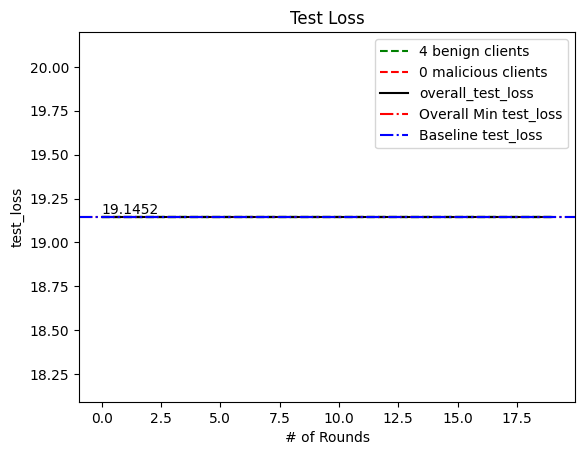

In [65]:
import matplotlib.pyplot as plt

x = range(num_rounds)
metric_type = "test_loss"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'overall_{metric_type}')

# Add a horizontal line for baseline min and overall min losses
if 'loss' in metric_type:
    plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type}')
else:
    plt.axhline(y=np.max(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Max {metric_type}')
plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom')

# Add axis labels and title
plt.title(f'Test Loss')
plt.xlabel(f'# of Rounds')
plt.ylabel(f'{metric_type}')

# Create legend with custom labels
plt.legend()

plt.show()


## To create a grid output

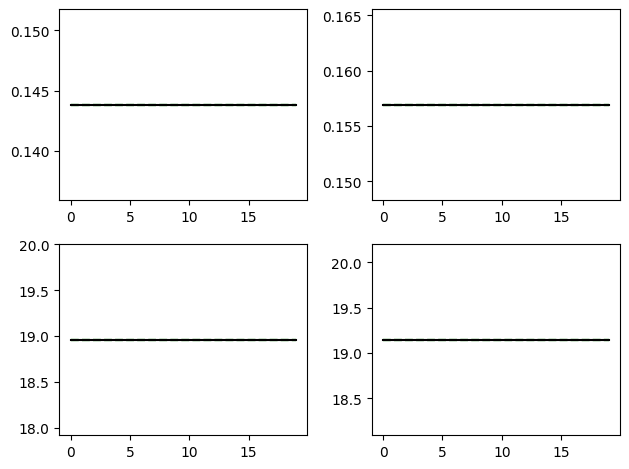

In [66]:
import matplotlib.pyplot as plt

def plot_1(ax):
    x = range(num_rounds)
    metric_type = "training_accuracy"

    for i in range(len(graph_data[metric_type])):
        if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        else:
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')

    ax.plot(x, graph_data[f'overall_{metric_type}'], color='black')

def plot_2(ax):
    x = range(num_rounds)
    metric_type = "test_accuracy"

    for i in range(len(graph_data[metric_type])):
        if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        else:
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')

    ax.plot(x, graph_data[f'overall_{metric_type}'], color='black')

def plot_3(ax):
    x = range(num_rounds)
    metric_type = "training_loss"

    for i in range(len(graph_data[metric_type])):
        if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        else:
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')

    ax.plot(x, graph_data[f'overall_{metric_type}'], color='black')

def plot_4(ax):
    x = range(num_rounds)
    metric_type = "test_loss"

    for i in range(len(graph_data[metric_type])):
        if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        else:
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')

    ax.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2)

# Plot each function in a separate subplot
plot_funcs = [plot_1, plot_2, plot_3, plot_4]

for i in range(2):
    for j in range(2):
        plot_funcs[i * 2 + j](axs[i, j])

# Adjust layout
plt.tight_layout()

# Create a common legend outside the subplots
# fig.legend([label for label in graph_data["training_accuracy"].keys()] + [f'overall_training_accuracy'], loc='upper right')

# Show plot
plt.show()